<a href="https://colab.research.google.com/github/Sidhtang/bert-project/blob/main/BERT_for_sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
# Get the current working directory
current_folder = os.getcwd()

dataset = tf.keras.utils.get_file(
    fname ="aclImdb.tar.gz",
    origin ="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    cache_dir=  current_folder,
    extract = True)

In [4]:
dataset_path = os.path.dirname(dataset)
# Check the dataset
os.listdir(dataset_path)

['aclImdb', 'aclImdb.tar.gz']

In [5]:
# Dataset directory
dataset_dir = os.path.join(dataset_path, 'aclImdb')

# Check the Dataset directory
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'README', 'train', 'imdb.vocab']

In [6]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['unsupBow.feat',
 'urls_neg.txt',
 'unsup',
 'neg',
 'urls_unsup.txt',
 'urls_pos.txt',
 'pos',
 'labeledBow.feat']

In [7]:

for file in os.listdir(train_dir):
    file_path = os.path.join(train_dir, file)
    # Check if it's a file (not a directory)
    if os.path.isfile(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            first_value = f.readline().strip()
            print(f"{file}: {first_value}")
    else:
        print(f"{file}: {file_path}")

unsupBow.feat: 0 0:8 1:6 3:5 4:2 5:1 7:1 8:5 9:2 10:1 11:2 13:3 16:1 17:1 18:1 19:1 22:3 24:1 26:3 28:1 30:1 31:1 35:2 36:1 39:2 40:1 41:2 46:2 47:1 48:1 52:1 63:1 67:1 68:1 74:1 81:1 83:1 87:1 104:1 105:1 112:1 117:1 131:1 151:1 155:1 170:1 198:1 225:1 226:1 288:2 291:1 320:1 331:1 342:1 364:1 374:1 384:2 385:1 407:1 437:1 441:1 465:1 468:1 470:1 519:1 595:1 615:1 650:1 692:1 851:1 937:1 940:1 1100:1 1264:1 1297:1 1317:1 1514:1 1728:1 1793:1 1948:1 2088:1 2257:1 2358:1 2584:2 2645:1 2735:1 3050:1 4297:1 5385:1 5858:1 7382:1 7767:1 7773:1 9306:1 10413:1 11881:1 15907:1 18613:1 18877:1 25479:1
urls_neg.txt: http://www.imdb.com/title/tt0064354/usercomments
unsup: /content/datasets/aclImdb/train/unsup
neg: /content/datasets/aclImdb/train/neg
urls_unsup.txt: http://www.imdb.com/title/tt0018515/usercomments
urls_pos.txt: http://www.imdb.com/title/tt0453418/usercomments
pos: /content/datasets/aclImdb/train/pos
labeledBow.feat: 9 0:9 1:1 2:4 3:4 4:6 5:4 6:2 7:2 8:4 10:4 12:2 26:1 27:1 28:1 29

In [8]:
def load_dataset(directory):
    data = {"sentence": [], "sentiment": []}
    for file_name in os.listdir(directory):
        print(file_name)
        if file_name == 'pos':
            positive_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(positive_dir):
                text = os.path.join(positive_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(1)
        elif file_name == 'neg':
            negative_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(negative_dir):
                text = os.path.join(negative_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(0)

    return pd.DataFrame.from_dict(data)

In [9]:
# Load the dataset from the train_dir
train_df = load_dataset(train_dir)
print(train_df.head())

unsupBow.feat
urls_neg.txt
unsup
neg
urls_unsup.txt
urls_pos.txt
pos
labeledBow.feat
                                            sentence  sentiment
0  We expected something great when we went to se...          0
1  When the film began, I was shocked to see it w...          0
2  And that is the only reason I posses this DVD....          0
3  C'mon people, you can't be serious, another ca...          0
4  I know a few things that are worst. A few. It ...          0


In [10]:

test_dir = os.path.join(dataset_dir,'test')

# Load the dataset from the train_dir
test_df = load_dataset(test_dir)
print(test_df.head())

urls_neg.txt
neg
urls_pos.txt
pos
labeledBow.feat
                                            sentence  sentiment
0  PLEASE?! If this is about technology and what ...          0
1  I love movies, all genres, and from big dollar...          0
2  This film is in a dead tie with the original f...          0
3  Do these guys take have a computer kick out th...          0
4  Joe D'Amato might have made some other notable...          0


In [11]:
sentiment_counts = train_df['sentiment'].value_counts()

fig =px.bar(x= {0:'Negative',1:'Positive'},
            y= sentiment_counts.values,
            color=sentiment_counts.index,
            color_discrete_sequence =  px.colors.qualitative.Dark24,
            title='<b>Sentiments Counts')

fig.update_layout(title='Sentiments Counts',
                  xaxis_title='Sentiment',
                  yaxis_title='Counts',
                  template='plotly_dark')

# Show the bar chart
fig.show()
pyo.plot(fig, filename = 'Sentiments Counts.html', auto_open = True)

'Sentiments Counts.html'

In [12]:
def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

In [13]:
# Train dataset
train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning).tolist()
# Test dataset
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)

<ipython-input-12-4a9c92faa406>:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

<ipython-input-12-4a9c92faa406>:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [14]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
    all_text = " ".join(text)
    wordcloud = WordCloud(width=800,
                          height=400,
                          stopwords=set(STOPWORDS),
                          background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()


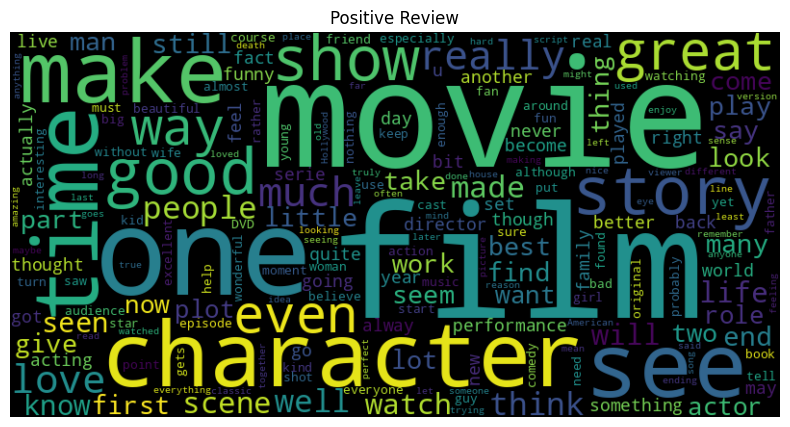

In [15]:
positive = train_df[train_df['sentiment']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')

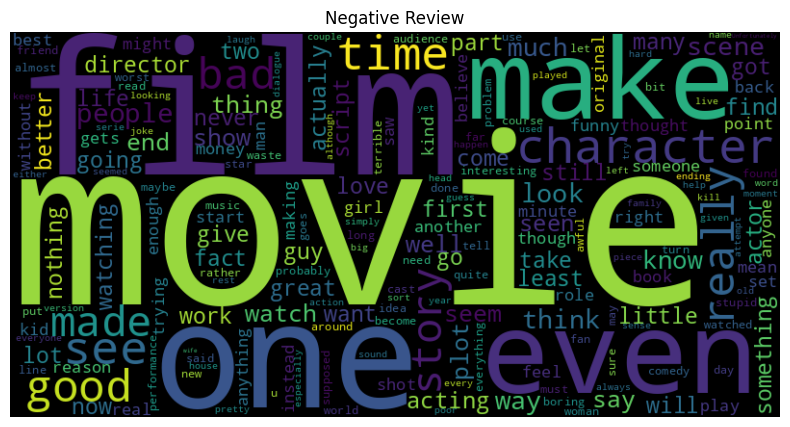

In [16]:
negative = train_df[train_df['sentiment']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(negative,'Negative Review')

In [17]:
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df['Cleaned_sentence']
Target = train_df['sentiment']

# Test data
#test_reviews =  "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']

In [18]:
x_val, x_test, y_val, y_test = train_test_split(test_reviews,
                                                    test_targets,
                                                    test_size=0.5,
                                                    stratify = test_targets)

In [19]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



In [20]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

In [21]:
k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Target[k])

Training Comments -->> We expected something great when we went to see this bomb It is basically a Broadway play put on film The music is plain terrible There isn't one memorable song in the movie  heard any hits from this movie You won't because there aren't any Some of the musical numbers go on so long that I got up to go to the restroom and get some pop corn and it was still going when I got back If they were good songs well  but they suck The pace is slow, terrible character development The lead was praised for her singing but sounded like she screamed every song  it was almost impossible to stand This movie has NOTHING to offer anyone but diehard Broadway enthusiasts This is without a doubt the most over rated movie I've seen in my entire life A complete waist of time and money There is nothing memorable about this movie except Danny Glover  who wasn't on screen enough and whose character wasn't developed enough Rent the video and you'll agree  this movie was an expensive, over pr

In [22]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
# Step 5: Train the model
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    Target,
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
    batch_size=32,
    epochs=3
)

Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 44/782 [>.............................] - ETA: 9:05:43 - loss: 0.6489 - accuracy: 0.6101